# Door Dash Data Exploratory Data Analysis/Model Fitting


This notebook will 'explore' the dataset we are working with before making any assumptions. This will help guide my decisions when 'transforming' my raw formatted data into production level data so it can be stored into our data warehouse (SnowFlake).


<b> Problem </b> : Lets assume for now this data is being used to create a machine learning model that can help predict whether or not the driver will receive a tip. I will gear my data transformation to cater to a machine learning dataset.

In [18]:
## Import common packages and 
import pandas as pd
import numpy as np
import boto3
from utils import io
import config
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LogisticRegression
import seaborn as sns



#

# Loading our Data

Lets take a look at the raw data. We can take a look at we we are dealing with by first listing out all raw data files in our bucket.

In [2]:
print(io.listfiles('raw'))

['raw/1.csv', 'raw/10.csv', 'raw/11.csv', 'raw/12.csv', 'raw/13.csv', 'raw/14.csv', 'raw/15.csv', 'raw/16.csv', 'raw/17.csv', 'raw/18.csv', 'raw/19.csv', 'raw/2.csv', 'raw/20.csv', 'raw/21.csv', 'raw/22.csv', 'raw/23.csv', 'raw/24.csv', 'raw/25.csv', 'raw/26.csv', 'raw/27.csv', 'raw/28.csv', 'raw/29.csv', 'raw/3.csv', 'raw/30.csv', 'raw/31.csv', 'raw/4.csv', 'raw/5.csv', 'raw/6.csv', 'raw/7.csv', 'raw/8.csv', 'raw/9.csv']


Lets look at the schema of these tables. We can import a csv file using the imp_file from the io module. We simply give it the directory of the file and the file name itself.

In [3]:
## Loading in dataframe of day 2
df = io.imp_file('raw','2')

In [4]:
#Schema
df.dtypes

Unnamed: 0.1                               int64
Unnamed: 0                                 int64
Customer_placed_order_datetime            object
Placed_order_with_restaurant_datetime     object
Driver_at_restaurant_datetime             object
Delivered_to_consumer_datetime            object
Driver_ID                                  int64
Restaurant_ID                              int64
Consumer_ID                                int64
Is_New                                      bool
Delivery_Region                           object
Is_ASAP                                     bool
Order_total                              float64
Amount_of_discount                       float64
Amount_of_tip                            float64
Refunded_amount                          float64
Total_time_elapsed                        object
Day                                        int64
dtype: object

In [7]:
# Checking if there are any na values for columns
df.isna().any()


Unnamed: 0.1                             False
Unnamed: 0                               False
Customer_placed_order_datetime           False
Placed_order_with_restaurant_datetime     True
Driver_at_restaurant_datetime             True
Delivered_to_consumer_datetime           False
Driver_ID                                False
Restaurant_ID                            False
Consumer_ID                              False
Is_New                                   False
Delivery_Region                          False
Is_ASAP                                  False
Order_total                              False
Amount_of_discount                       False
Amount_of_tip                            False
Refunded_amount                          False
Total_time_elapsed                       False
Day                                      False
dtype: bool

In [12]:
df.isna().sum()


Unnamed: 0.1                               0
Unnamed: 0                                 0
Customer_placed_order_datetime             0
Placed_order_with_restaurant_datetime      2
Driver_at_restaurant_datetime            103
Delivered_to_consumer_datetime             0
Driver_ID                                  0
Restaurant_ID                              0
Consumer_ID                                0
Is_New                                     0
Delivery_Region                            0
Is_ASAP                                    0
Order_total                                0
Amount_of_discount                         0
Amount_of_tip                              0
Refunded_amount                            0
Total_time_elapsed                         0
Day                                        0
dtype: int64

There seems to be large amount of NaN values in the field 'Driver_at_restaurant_datetime'. However, since we will not be using this variable as one of our predictors I will simply drop the column. We can also remove a few the other fields that have no relevance to our goal (Indexes,IDs)

# Data Transformation

Lets first remove irrelavent columns.

In [4]:
## DF version 1  Here we are simply dropping irrelavent columns
v1 = df.drop(columns=['Customer_placed_order_datetime','Placed_order_with_restaurant_datetime','Unnamed: 0.1','Unnamed: 0','Driver_ID','Restaurant_ID','Consumer_ID','Driver_at_restaurant_datetime','Delivered_to_consumer_datetime'])

In [5]:
v1

,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount,Total_time_elapsed,Day
0,False,Palo Alto,True,52.71,0.0,4.29,0.0,0 days 01:04:18.000000000,2
1,False,Palo Alto,False,31.89,0.0,3.56,0.0,0 days 01:33:31.000000000,2
2,False,Palo Alto,True,73.32,0.0,3.09,0.0,0 days 00:32:49.000000000,2
3,False,Palo Alto,True,45.10,0.0,2.26,0.0,0 days 00:40:54.000000000,2
4,False,Palo Alto,True,62.98,0.0,3.15,0.0,0 days 00:47:35.000000000,2
...,...,...,...,...,...,...,...,...,...
569,False,Palo Alto,False,52.00,6.0,2.11,0.0,0 days 01:14:40.000000000,2
570,False,Palo Alto,False,151.74,6.0,12.85,0.0,0 days 01:26:29.000000000,2
571,False,Mountain View,True,22.31,6.0,2.00,0.0,0 days 00:29:19.000000000,2
572,False,Mountain View,True,14.65,6.0,1.19,0.0,0 days 00:22:11.000000000,2


### Feature Engineering

We can also add new fields to improve the performance of our machine learning model.

1. First, lets notice that the `Total_time_elapsed` field is not quantitative. We would want to change the field type to float such that it represents the total amount of time taken in minutes

2. Secondly, we have 3 categorical fields that can be One-Hot-Encoded `Is_New` , `Delivery_Region`, and `Is_ASAP`

3. We need to create a new binary field for our response variable

Lets do these three below:

##### Converting `Total_time_elapsed` to `Total Minutes`

In [6]:
def get_total_minutes(time_str):
    # Split the string to get the hours, minutes, and seconds components
    time_parts = time_str.split(' ')[-1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2].split('.')[0])
    microseconds = int(time_parts[2].split('.')[1])
    
    # Create a timedelta object representing the time difference
    time_diff = datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds, microseconds=microseconds)
    
    # Calculate the total number of minutes
    total_minutes = time_diff.total_seconds() // 60
    
    return total_minutes
# Convert the field 'Totol_time_elapsed' to total number of minues
v1['Total Minutes'] = v1['Total_time_elapsed'].apply(get_total_minutes)

# Lets drop the old column
v2 = v1.drop(columns=['Total_time_elapsed'])

##### One hot encoding categorical fields (`Is_New`,`Delivery_Region`,`Is_ASAP`)

In [7]:
v3 = pd.get_dummies(v2, columns=['Is_New','Delivery_Region','Is_ASAP'])

##### Adding our response variable


In [19]:
v3['Tip?'] = np.where(v3['Amount_of_tip'] == 0, 0, 1)
finalv = v3.drop(columns=['Amount_of_tip'])
finalv

,Order_total,Amount_of_discount,Refunded_amount,Day,Total Minutes,Is_New_False,Is_New_True,Delivery_Region_Mountain View,Delivery_Region_None,Delivery_Region_Palo Alto,Delivery_Region_San Jose,Is_ASAP_False,Is_ASAP_True,Tip?
0,52.71,0.0,0.0,2,64.0,1,0,0,0,1,0,0,1,1
1,31.89,0.0,0.0,2,93.0,1,0,0,0,1,0,1,0,1
2,73.32,0.0,0.0,2,32.0,1,0,0,0,1,0,0,1,1
3,45.10,0.0,0.0,2,40.0,1,0,0,0,1,0,0,1,1
4,62.98,0.0,0.0,2,47.0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,52.00,6.0,0.0,2,74.0,1,0,0,0,1,0,1,0,1
570,151.74,6.0,0.0,2,86.0,1,0,0,0,1,0,1,0,1
571,22.31,6.0,0.0,2,29.0,1,0,1,0,0,0,0,1,1
572,14.65,6.0,0.0,2,22.0,1,0,1,0,0,0,0,1,1


<b>Great!</b> Now we are ready to fit our model.

# Exploratory Data Analysis



Before we fit our model, lets do some quick EDA. Since I know what 

In [ ]:
er

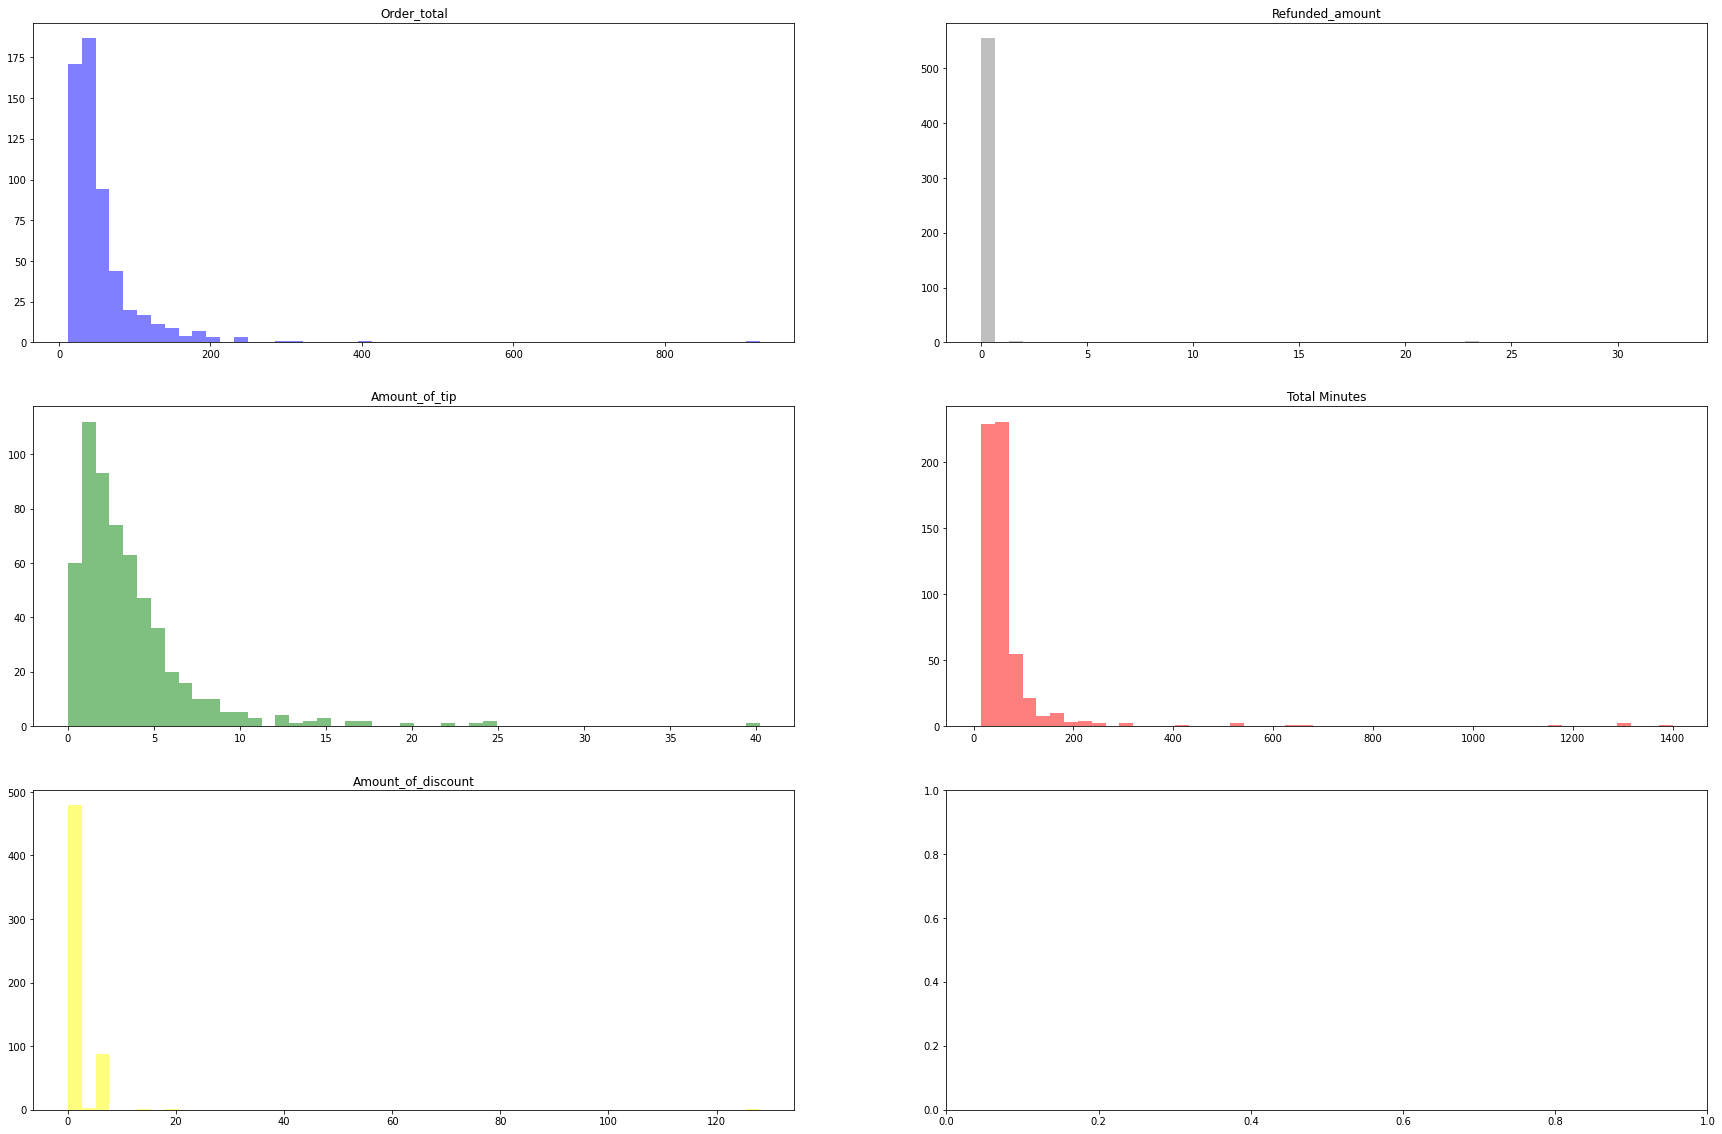

In [56]:
import numpy as np

# Generate some random data
data1 = v3['Order_total']
data2 = v3['Amount_of_tip']
data3 = v3['Total Minutes']
data4 = v3['Refunded_amount']
data5 = v3['Amount_of_discount']


# Create a figure with two subplots
fig, axs = plt.subplots(3, 2,figsize = (30,20))

# Plot the histograms in each subplot
axs[0][0].hist(data1, bins=50, color='blue', alpha=0.5)
axs[0][0].set_title('Order_total')
axs[1][0].hist(data2, bins=50,color='green', alpha=0.5)
axs[1][0].set_title('Amount_of_tip')
axs[1][1].hist(data3,  bins=50,color='red', alpha=0.5)
axs[1][1].set_title('Total Minutes')
axs[0][1].hist(data4, bins=50, color='gray', alpha=0.5)
axs[0][1].set_title('Refunded_amount')
axs[2][0].hist(data5, bins=50, color='yellow', alpha=0.5)
axs[2][0].set_title('Amount_of_discount')



# Display the figure
plt.show()

We can see that the distribution of all quantitative variables are right skewed.

Lets also visualize the relationship between our independent and dependent variables. 



In [20]:
finalv

,Order_total,Amount_of_discount,Refunded_amount,Day,Total Minutes,Is_New_False,Is_New_True,Delivery_Region_Mountain View,Delivery_Region_None,Delivery_Region_Palo Alto,Delivery_Region_San Jose,Is_ASAP_False,Is_ASAP_True,Tip?
0,52.71,0.0,0.0,2,64.0,1,0,0,0,1,0,0,1,1
1,31.89,0.0,0.0,2,93.0,1,0,0,0,1,0,1,0,1
2,73.32,0.0,0.0,2,32.0,1,0,0,0,1,0,0,1,1
3,45.10,0.0,0.0,2,40.0,1,0,0,0,1,0,0,1,1
4,62.98,0.0,0.0,2,47.0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,52.00,6.0,0.0,2,74.0,1,0,0,0,1,0,1,0,1
570,151.74,6.0,0.0,2,86.0,1,0,0,0,1,0,1,0,1
571,22.31,6.0,0.0,2,29.0,1,0,1,0,0,0,0,1,1
572,14.65,6.0,0.0,2,22.0,1,0,1,0,0,0,0,1,1


<AxesSubplot:xlabel='Total Minutes', ylabel='Tip?'>

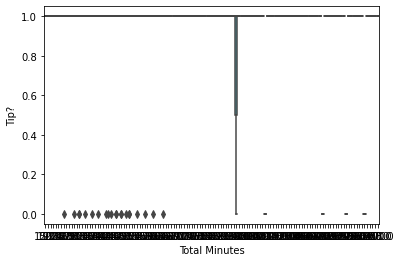

In [24]:
sns.boxplot(x='Total Minutes', y='Tip?', data=finalv)


# Model Fitting

There are quite a few classifications methods in machine learning. In this notebook, we will only be taking a look at two. `Logistic regression` and `Random Forests`.

e



